In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/pytorch-optimizers/')

In [2]:
import os
import gc
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import imagehash
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
import torch
from fastai.vision.all import *

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

# Configuration

In [3]:
CFG = {
    "use_num"     : 99999,
    "seed"        : 42,
    'device'      : "cuda:0" if torch.cuda.is_available() else "cpu",
    "input_trimg" : '../input/petfinder-pawpularity-score/train/',
    "input_trpath": '../input/petfinder-pawpularity-score/train.csv',
    "input_eximg" : '../input/petfinder-adoption-prediction/train_images/',
    "input_expath": '../input/petfinder-adoption-prediction/train/train.csv',
    "output_path" : './',
    "models"      : [[512, "tf_efficientnet_b5_ns", "../input/petfinder-fastai-models-pseudolabel-1/petfinder_effnet_binary_fastai_0.pth"],
                     [512, "tf_efficientnet_b5_ns", "../input/petfinder-fastai-models-pseudolabel-1/petfinder_effnet_binary_fastai_1.pth"],
                     [512, "tf_efficientnet_b5_ns", "../input/petfinder-fastai-models-pseudolabel-1/petfinder_effnet_binary_fastai_2.pth"],
                     [512, "tf_efficientnet_b5_ns", "../input/petfinder-fastai-models-pseudolabel-1/petfinder_effnet_binary_fastai_3.pth"],
                     [224, "swin_large_patch4_window7_224_in22k", "../input/petfinder-fastai-models-pseudolabel-2/petfinder_swin_binary_fastai_0.pth"],
                     [224, "swin_large_patch4_window7_224_in22k", "../input/petfinder-fastai-models-pseudolabel-2/petfinder_swin_binary_fastai_1.pth"],
                     [224, "swin_large_patch4_window7_224_in22k", "../input/petfinder-fastai-models-pseudolabel-2/petfinder_swin_binary_fastai_2.pth"],
                     [224, "swin_large_patch4_window7_224_in22k", "../input/petfinder-fastai-models-pseudolabel-2/petfinder_swin_binary_fastai_3.pth"]],
    "tta"         : 2,
    "batch_size"  : 128,
    "num_workers" : 4
}

CFG

{'use_num': 99999,
 'seed': 42,
 'device': 'cuda:0',
 'input_trimg': '../input/petfinder-pawpularity-score/train/',
 'input_trpath': '../input/petfinder-pawpularity-score/train.csv',
 'input_eximg': '../input/petfinder-adoption-prediction/train_images/',
 'input_expath': '../input/petfinder-adoption-prediction/train/train.csv',
 'output_path': './',
 'models': [[512,
   'tf_efficientnet_b5_ns',
   '../input/petfinder-fastai-models-pseudolabel-1/petfinder_effnet_binary_fastai_0.pth'],
  [512,
   'tf_efficientnet_b5_ns',
   '../input/petfinder-fastai-models-pseudolabel-1/petfinder_effnet_binary_fastai_1.pth'],
  [512,
   'tf_efficientnet_b5_ns',
   '../input/petfinder-fastai-models-pseudolabel-1/petfinder_effnet_binary_fastai_2.pth'],
  [512,
   'tf_efficientnet_b5_ns',
   '../input/petfinder-fastai-models-pseudolabel-1/petfinder_effnet_binary_fastai_3.pth'],
  [224,
   'swin_large_patch4_window7_224_in22k',
   '../input/petfinder-fastai-models-pseudolabel-2/petfinder_swin_binary_fastai_

In [4]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def softmax(x):
    max = np.max(x,axis=1,keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x,axis=1,keepdims=True)
    return e_x / sum 

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [5]:
df_exdata = pd.DataFrame([f"{CFG['input_eximg']}{i}" for i in os.listdir(CFG['input_eximg'])], columns=["path"])
df_exdata["Pawpularity"] = 0  # Dummy
if  CFG["use_num"] < df_exdata.shape[0]:
    df_exdata = df_exdata.sample(CFG["use_num"]).reset_index(drop=True)

print(df_exdata.shape)
df_exdata.head()

(58311, 2)


,path,Pawpularity
0,../input/petfinder-adoption-prediction/train_images/cf8d949f9-2.jpg,0
1,../input/petfinder-adoption-prediction/train_images/61d4dc56b-12.jpg,0
2,../input/petfinder-adoption-prediction/train_images/53923463d-9.jpg,0
3,../input/petfinder-adoption-prediction/train_images/0173c456c-8.jpg,0
4,../input/petfinder-adoption-prediction/train_images/fa7c7d1be-3.jpg,0


In [6]:
class Model(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, 1)

    def forward(self, x):
        output = self.model(x)
        return output

class SwinModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        num_features = self.model.num_features
        self.linear  = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.model(x)
        output = self.linear(x)
        return output

In [7]:
def prepare_dataloader(df, size):
    df = df.copy()
    label_col  = "Pawpularity"
    dataloader = ImageDataLoaders.from_df(
        df,
        valid_pct=0.2,  # Dummy
        seed=CFG["seed"],
        fn_col='path',
        label_col=label_col,
        y_block=RegressionBlock,
        bs=CFG['batch_size'],
        num_workers=CFG['num_workers'],
        item_tfms=Resize(size),
        batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
    )
    return dataloader

def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [8]:
def get_learner(df, size, model, model_path):
    dataloader = prepare_dataloader(df, size)
    if -1 < model.find("swin"):
        model = SwinModel(model, pretrained=False)
    else:
        model = Model(model, pretrained=False)
    model.load_state_dict(torch.load(model_path))
    learner = Learner(
        dataloader,
        model,
        loss_func=BCEWithLogitsLossFlat(),
        metrics=petfinder_rmse).to_fp16()
    return learner, dataloader

In [9]:
all_res = []
for size, model, model_path in CFG['models']:
    learn, data_loader = get_learner(df_exdata, size, model, model_path)
    data_loader = data_loader.test_dl(df_exdata)
    res, _ = learn.tta(dl=data_loader, n=CFG["tta"], beta=0)
    res    = res.detach().numpy()
    if -1 < model_path.find("binary"):
        res = res*100
    all_res.append(res)

    del learn, data_loader

In [10]:
df_pseudolabel = pd.DataFrame(np.array(all_res).reshape(len(CFG["models"]),-1)).T
df_exdata["Pawpularity"] = df_pseudolabel.mean(1)

In [11]:
print(df_exdata.shape)
df_exdata.head()

(58311, 2)


,path,Pawpularity
0,../input/petfinder-adoption-prediction/train_images/cf8d949f9-2.jpg,33.240162
1,../input/petfinder-adoption-prediction/train_images/61d4dc56b-12.jpg,23.821459
2,../input/petfinder-adoption-prediction/train_images/53923463d-9.jpg,33.153225
3,../input/petfinder-adoption-prediction/train_images/0173c456c-8.jpg,27.282467
4,../input/petfinder-adoption-prediction/train_images/fa7c7d1be-3.jpg,42.298103


<AxesSubplot:>

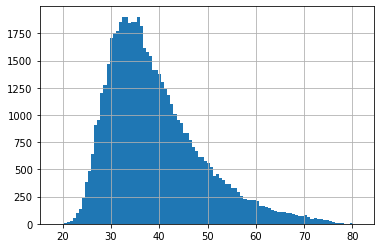

In [12]:
df_exdata.Pawpularity.hist(bins=100)

In [13]:
df_exdata.to_csv("train.csv", index=False)